In [1]:
print("hello")

hello


# **Enhance LLMs using RAG and Hugging Face**


Imagine you've been hired to help the HR department build an intelligent question-answering tool for company policies. Employees can input questions such as "What is our vacation policy?" or "How do I submit a reimbursement request?" and receive instant, clear answers. This tool would save time and help employees understand complex policy documents easily, by automatically providing relevant information instead of searching through pages of text.


In this lab, you'll delve into the advanced concept of Retriever-Augmented Generation (RAG), a cutting-edge approach in natural language processing that synergistically combines the powers of retrieval and generation. You will explore how to effectively retrieve relevant information from a large dataset and then use a state-of-the-art sequence-to-sequence model to generate precise answers to complex questions. By integrating tools such as the Dense Passage Retriever (DPR) and the GPT2 model for generation, this lab will equip you with the skills to build a sophisticated question-answering system that can find and synthesize information on-the-fly. Through hands-on coding exercises and implementations, you will gain practical experience in handling real-world NLP challenges, setting up a robust natural language processing (NLP) pipeline, and fine-tuning models to enhance their accuracy and relevance.


## Objectives


- **Understand the concept and components:** Grasp the fundamentals of Retriever-Augmented Generation (RAG), focusing on how retrieval and generation techniques are combined in natural language processing (NLP).
- **Implement Dense Passage Retriever (DPR):** Learn to set up and use DPR to efficiently retrieve documents from a large dataset, which is crucial for feeding relevant information into generative models.
- **Integrate sequence-to-sequence models:** Explore integrating sequence-to-sequence models such as GPT2 to generate answers based on the contexts provided by DPR, enhancing the accuracy and relevance of responses.
- **Build a Question-Answering System:** Gain practical experience by developing a question-answering system that utilizes both DPR and GPT2, mimicking real-world applications.
- **Fine-tune and optimize NLP models:** Acquire skills in fine-tuning and optimizing NLP models to improve their performance and suitability for specific tasks or datasets.
- **Use professional NLP tools:** Get familiar with using advanced NLP tools and libraries, such as Hugging Face’s transformers and dataset libraries, to implement sophisticated NLP solutions.


In this lab, you'll use several libraries tailored for natural language processing, data manipulation, and efficient computation:

- **[wget](https://pypi.org/project/wget/)**: Used to download files from the internet, essential for fetching datasets or pretrained models.

- **[torch](https://pytorch.org/)**: PyTorch library, fundamental for machine learning and neural network operations, provides GPU acceleration and dynamic neural network capabilities.

- **[numpy](https://numpy.org/)**: A staple for numerical operations in Python, used for handling arrays and matrices.

- **[faiss](https://github.com/facebookresearch/faiss)**: Specialized for efficient similarity search and clustering of dense vectors, crucial for information retrieval tasks.

- **[transformers](https://huggingface.co/transformers/)**: Offers a multitude of pretrained models for a variety of NLP tasks, for example:
  
  **DPRQuestionEncoder**, **DPRContextEncoder**: Encode questions and contexts into vector embeddings for retrieval.

- **[tokenizers](https://huggingface.co/docs/tokenizers/)**: Tools that convert input text into numerical representations (tokens) compatible with specific models, ensuring effective processing and understanding by the models, for example:

  **[DPRQuestionEncoderTokenizer](https://huggingface.co/transformers/model_doc/dpr.html)**, **[DPRContextEncoderTokenizer](https://huggingface.co/transformers/model_doc/dpr.html)**: Convert text into formats suitable for their respective models, ensuring optimal performance for processing and generating text.

These tools are integral to developing the question-answering system in this lab, covering everything from data downloading and preprocessing to advanced machine learning tasks.


In [1]:
pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=dc390228a5f08b930a2f231b15040b40ebd990497e23b051ec936d948dcbee0c
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [2]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 27.7 MB/s eta 0:00:00


In [3]:
import wget
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer
import torch

import numpy as np
import random
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import numpy as np

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [4]:
def tsne_plot(data):
    # Apply t-SNE to reduce to 3D
    tsne = TSNE(n_components=3, random_state=42,perplexity=data.shape[0]-1)
    data_3d = tsne.fit_transform(data)

    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Assign colors for each point based on its index
    num_points = len(data_3d)
    colors = plt.cm.tab20(np.linspace(0, 1, num_points))

    # Plot scatter with unique colors for each point
    for idx, point in enumerate(data_3d):
        ax.scatter(point[0], point[1], point[2], label=str(idx), color=colors[idx])

    # Adding labels and titles
    ax.set_xlabel('TSNE Component 1')
    ax.set_ylabel('TSNE Component 2')
    ax.set_zlabel('TSNE Component 3')
    plt.title('3D t-SNE Visualization')
    plt.legend(title='Input Order')
    plt.show()

# Load and preprocess data

This part of the lab focuses on loading and preparing the text data for the question-answering system. You will start by downloading a specific text file and then reading and preprocessing it to make it suitable for NLP tasks.

## Downloading the text file

The `wget` library is used to download the text file containing the data. This file, named `companyPolicies.txt`, contains various company policies formatted in plain text. Here is how you download it:


In [5]:
filename = 'companyPolicies.txt'
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/6JDbUb_L3egv_eOkouY71A.txt'

# Use wget to download the file
wget.download(url, out=filename)
print('file downloaded')

file downloaded


## Reading and preprocessing the data
Once the file is downloaded, the next step is to read and preprocess the text. This involves opening the file, reading its contents, and splitting the text into individual paragraphs. Each paragraph represents a section of the company policies. You can also filter out any empty paragraphs to clean your dataset:


In [6]:
def read_and_split_text(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
    # Split the text into paragraphs (simple split by newline characters)
    paragraphs = text.split('\n')
    # Filter out any empty paragraphs or undesired entries
    paragraphs = [para.strip() for para in paragraphs if len(para.strip()) > 0]
    return paragraphs

# Read the text file and split it into paragraphs
paragraphs = read_and_split_text('companyPolicies.txt')
paragraphs[0:10]

['1.\tCode of Conduct',
 'Our Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability.',
 'Integrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest.',
 "Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy.",
 'Accountability: We take responsibility for our actions and decisions. We follow all relevant laws and regulations, and we strive to continuously improve our practices. We report any potent

In [7]:
for i in range(4):
    print(f"sample: {i} paragraph: {paragraphs[i]} \n" )

sample: 0 paragraph: 1.	Code of Conduct 

sample: 1 paragraph: Our Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability. 

sample: 2 paragraph: Integrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest. 

sample: 3 paragraph: Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy. 



You are encouraged to substitute `companyPolicies.txt` with any other text file or set of files relevant to your interests or projects. This allows for experimentation with different types of content and formats, enhancing your learning experience and adaptability of the skills taught in this lab.


# Building the retriever: Encoding and indexing
Encoding documents involves converting the text into numerical data that computers can process. This process starts by cleaning the text and then using special tools to transform the words into numerical representations (vectors). These vectors make it easier to search and retrieve relevant documents based on what the user is looking for.

In this section, you will prepare your text data for efficient retrieval by encoding the paragraphs into vector embeddings, i.e., contextual embeddings, and then indexing these embeddings using FAISS. This allows your question-answering system to quickly find the most relevant information when processing queries.


## Encoding texts into embeddings

Let's use the Dense Passage Retriever (DPR) model, specifically the context encoder, to convert your preprocessed text data into dense vector embeddings. These embeddings capture the semantic meanings of the texts, enabling effective similarity-based retrieval. DPR models, such as the the DPRContextEncoder and DPRContextEncoderTokenizer, are built on the BERT architecture but specialize in dense passage retrieval. They differ from BERT in their training, which focuses on contrastive learning for retrieving relevant passages, while BERT is more general-purpose, handling various NLP tasks.


Let's break down each step:


**1. Tokenization**: Each text is tokenized to format it in a way that is compatible with the encoder. This involves converting text into a sequence of tokens with attention masks, ensuring uniform length through padding and managing text size through truncation.


```DPRContextEncoderTokenizer``` object is identical to ```BertTokenizer``` and runs end-to-end tokenization including punctuation splitting and wordpiece. Consider the following sample:



In [8]:
%%capture
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
context_tokenizer

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.


In [9]:
text = [("How are you?", "I am fine."), ("What's up?", "Not much.")]
print(text)

[('How are you?', 'I am fine.'), ("What's up?", 'Not much.')]


In [10]:
tokens_info=context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
tokens_info

{'input_ids': tensor([[ 101, 2129, 2024, 2017, 1029,  102, 1045, 2572, 2986, 1012,  102],
        [ 101, 2054, 1005, 1055, 2039, 1029,  102, 2025, 2172, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

- `token_type_ids`: These are segment embeddings used to distinguish different sentences or segments within the input. This is particularly useful in tasks that involve multiple types of input, such as question answering, where questions and context may need to be differentiated.

- `attention_mask`: The attention mask indicates which tokens should be attended to by the model. It has a value of 1 for actual tokens in the input sentences and 0 for padding tokens, ensuring that the model focuses only on meaningful data.

-  `input_ids`: These represent the indices of tokens in the tokenizer's vocabulary. To translate these indices back into readable tokens, you can use the method `convert_ids_to_tokens` provided by the tokenizer. Here's an example of how to use this method:


In [11]:
for s in tokens_info['input_ids']:
   print(context_tokenizer.convert_ids_to_tokens(s))

['[CLS]', 'how', 'are', 'you', '?', '[SEP]', 'i', 'am', 'fine', '.', '[SEP]']
['[CLS]', 'what', "'", 's', 'up', '?', '[SEP]', 'not', 'much', '.', '[SEP]']


**2. Encoding**: The tokenized texts are then fed into the `context_encoder`. This model processes the inputs and produces a pooled output for each, effectively compressing the information of an entire text into a single, dense vector embedding that represents the semantic essence of the text.

DPR models, including the ```DPRContextEncoder```, are based on the BERT architecture but specialize in dense passage retrieval. They differ from BERT in their training, which focuses on contrastive learning for retrieving relevant passages, while BERT is more general-purpose, handling various NLP tasks.


In [12]:
context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



The `context_tokenizer` and `context_encoder` work together to process text data, transforming paragraphs into contextual embeddings suitable for further NLP tasks. Here's how these components are applied to the first 20 paragraphs from a list:
   - The `context_tokenizer` takes the first 20 paragraphs and converts each into a sequence of token IDs, formatted specifically as input to a PyTorch model. This process includes:
     - **Padding**: To ensure uniformity, shorter text sequences are padded with zeros to reach the specified maximum length of 256 tokens.
     - **Truncation**: Longer texts are cut off at 256 tokens to maintain consistency across all inputs.
   - The tokenized data is then passed to the `context_encoder`, which processes these token sequences to produce contextual embeddings. Each output embedding vector from the encoder represents the semantic content of its corresponding paragraph, encapsulating key informational and contextual nuances.
   - The encoder outputs a PyTorch tensor where each row corresponds to a different paragraph's embedding. The shape of this tensor, determined by the number of paragraphs processed and the embedding dimensions, reflects the detailed, contextualized representation of each paragraph's content.


In [13]:
#shuffling samples so that the samples are not ordered based on the category they belong to
random.shuffle(paragraphs)

In [14]:
tokens=context_tokenizer( paragraphs[:20], return_tensors='pt', padding=True, truncation=True, max_length=256)
tokens
outputs=context_encoder(**tokens)
outputs.pooler_output

tensor([[ 0.3780,  0.7627,  0.0060,  ..., -0.8042, -0.6407, -0.3875],
        [ 1.0448,  0.4522, -0.0058,  ..., -0.1293, -0.4701,  0.0488],
        [ 0.4062,  0.0881,  0.2576,  ..., -0.5453, -0.7457, -0.2814],
        ...,
        [ 0.7075,  0.6072,  0.0172,  ..., -0.1247,  0.4195, -0.4397],
        [ 0.4570,  0.4176, -0.1697,  ..., -0.4451, -0.2361, -0.2666],
        [ 0.3383,  0.0612,  0.3355,  ..., -0.5211, -0.5702, -0.0316]],
       grad_fn=<SliceBackward0>)

**t-SNE (t-Distributed Stochastic Neighbor Embedding)** is an effective method for visualizing high-dimensional data, making it particularly useful for analyzing outputs from ```DPRContextEncoder``` models. The ```DPRContextEncoder``` encodes passages into dense vectors that capture their semantic meanings within a high-dimensional space. Applying t-SNE to these dense vectors allows you to reduce their dimensionality to two or three dimensions. This reduction creates a visual representation that preserves the relationships between passages, enabling you to explore clusters of similar passages and discern patterns that might otherwise remain hidden in the high-dimensional space. The resulting plots provide insights into how the model differentiates between different types of passages and reveal the inherent structure within the encoded data.


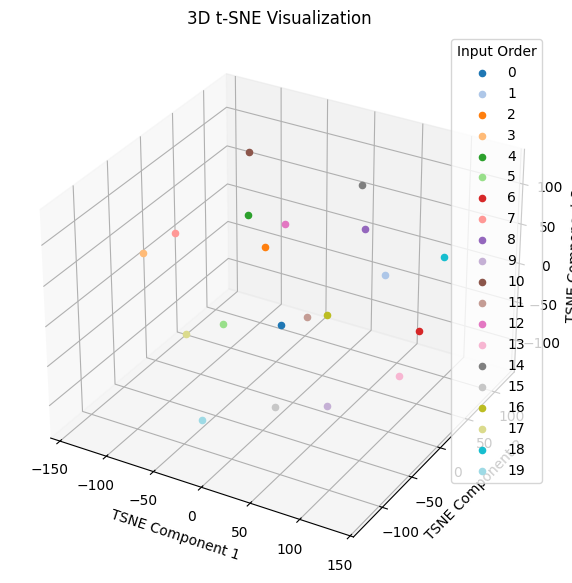

In [15]:
tsne_plot(outputs.pooler_output.detach().numpy())

Samples 16 and 12 are closer to each other on the graph shown above. Let's view the corresponding paragraphs:


In [16]:
print("sample 16:", paragraphs[16])
print("sample 12:", paragraphs[12])

sample 16: 8.	Anti-discrimination and Harassment Policy
sample 12: Policy Objective: The Drug and Alcohol Policy is established to establish clear expectations and guidelines for the responsible use of drugs and alcohol within the organization. This policy aims to maintain a safe, healthy, and productive workplace.


Both samples discuss diversity. Rather than relying solely on visual inspection, distances between embeddings are employed to determine the relevance of retrieved documents or passages. This involves comparing the query’s embedding with the embeddings of candidate documents, enabling a precise and objective measure of relevance.


 **3. Aggregation**: All individual embeddings generated from the texts are then aggregated into a single `NumPy` array. This aggregation is essential for subsequent processing steps, such as indexing, which facilitates efficient similarity searches.

This methodological approach efficiently transforms paragraphs into a form that retains crucial semantic information in a compact vector format, making it ideal for the retrieval tasks necessary in this lab. Now, compile a list containing each sample, where each sample has specific dimensions.


In [17]:
embeddings=[]
for text in paragraphs[0:5]:
    inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
    outputs = context_encoder(**inputs)
    embeddings.append(outputs.pooler_output)
    print("number of samples:")
    print(len(embeddings))
    print(" samples shape:")
    print(outputs.pooler_output.shape)

number of samples:
1
 samples shape:
torch.Size([1, 768])
number of samples:
2
 samples shape:
torch.Size([1, 768])
number of samples:
3
 samples shape:
torch.Size([1, 768])
number of samples:
4
 samples shape:
torch.Size([1, 768])
number of samples:
5
 samples shape:
torch.Size([1, 768])


In [18]:
torch.cat(embeddings).detach().numpy().shape

(5, 768)

In [19]:
def encode_contexts(text_list):
    # Encode a list of texts into embeddings
    embeddings = []
    for text in text_list:
        inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
        outputs = context_encoder(**inputs)
        embeddings.append(outputs.pooler_output)
    return torch.cat(embeddings).detach().numpy()

# you would now encode these paragraphs to create embeddings.
context_embeddings = encode_contexts(paragraphs)

In [29]:
len(paragraphs)

76

In [24]:
context_embeddings.shape ## we have embeddings for each 76 paragraphs

(76, 768)

## Creating and populating the FAISS index

After the text paragraphs are encoded into dense vector embeddings, the next crucial step is to create and populate an FAISS index. Facebook AI Similarity Search (FAISS) is an efficient library developed by Facebook for similarity search and clustering of dense vectors.

#### Overview of FAISS
- **Efficiency**: FAISS is designed for fast similarity search, which is particularly valuable when dealing with large datasets. It is highly suitable for tasks in natural language processing where retrieval speed is critical.
- **Scalability**: It effectively handles large volumes of data, maintaining performance even as dataset sizes increase.

#### Using IndexFlatL2
- **Index type**: `IndexFlatL2` is one of the simplest and most used indexes in FAISS. It computes the Euclidean distance (L2 norm) between the query vector and the dataset vectors to determine similarity. This method is straightforward but very effective for many use cases where the exact distance calculation is crucial.
- **Application**: This type of index is particularly useful in retrieval systems where the task is to find the most relevant documents or information that closely matches the query vector.


In [ ]:
pip install faiss-cpu

In [20]:
import faiss

# Convert list of numpy arrays into a single numpy array
embedding_dim = 768  # This should match the dimension of your embeddings
context_embeddings_np = np.array(context_embeddings).astype('float32')

# Create a FAISS index for the embeddings
index = faiss.IndexFlatL2(embedding_dim)
index.add(context_embeddings_np)  # Add the context embeddings to the index

# DPR question encoder and tokenizer
The Dense Passage Retriever (DPR) is instrumental in effectively retrieving relevant documents or passages for a given question. Let's load the ```DPRQuestionEncoder``` and ```DPRQuestionEncoderTokenizer``` for encoding questions:

- **Question encoder**: The DPR question encoder is designed to convert questions into dense vector embeddings. This process enhances the system's ability to efficiently match and retrieve relevant content from a vast corpus, which is vital for answering queries accurately.

- **Tokenizer**: The tokenizer for the DPR question encoder plays a crucial role in preparing input questions by:
  - **Standardizing text**: It converts raw text into a standardized sequence of token IDs.
  - **Processing inputs**: These token IDs are then processed by the question encoder to produce embeddings that effectively represent the semantic intent of the questions.

## Distinguishing DPR question and context components

While both the DPR question encoder and DPR context encoder serve crucial roles within the DPR framework, they are optimized for different aspects of the retrieval process:

- **DPR question encoder and tokenizer**: These components are specifically tuned to process and encode queries (questions). The question encoder transforms questions into dense embeddings, which are used to search through a corpus for the most relevant documents. The corresponding tokenizer standardizes the questions to ensure they are correctly formatted for the encoder.

- **DPR context encoder and tokenizer**: In contrast, the context encoder and its tokenizer are focused on encoding the potential answer passages or documents. This encoder creates embeddings from extensive texts, allowing the system to compare these with question embeddings to find the best match.


In [21]:
# Load DPR question encoder and tokenizer
question_encoder = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# Example query and context retrieval

In this part of the lab, you will demonstrate how to use the system to process a specific query and retrieve the most relevant contexts from your indexed data. This example will help illustrate how the different components of the system interact to perform a complete retrieval task.

First, process an example query by converting the raw text question into a format that the DPR question encoder can understand and then encode it into a dense vector. Using the encoded question, search your prebuilt FAISS index to find the most relevant contexts. This step showcases the practical use of the FAISS index in retrieving information based on query similarity.

After conducting the search for relevant contexts based on the question embedding, the output consists of two key components:

- **D (Distances)**: This array contains the distances between the query embedding and the retrieved document embeddings. The distances measure the similarity between the query and each document, where lower distances indicate higher relevance. These values help determine how closely each retrieved context matches the query.

- **I (Indices)**: This array holds the indices of the paragraphs within the `paragraphs` array that have been identified as the most relevant to the query. These indices correspond to the positions of the paragraphs in the original data array, allowing for easy retrieval of the actual text content.

The combination of `D` and `I` provides both a quantitative measure of relevance and the specific content that is most relevant, enabling a comprehensive response to the user's query.


In [22]:
# Example question
question = 'Drug and Alcohol Policy'
question_inputs = question_tokenizer(question, return_tensors='pt')
question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

# Search the index
D, I = index.search(question_embedding, k=5)  # Retrieve top 5 relevant contexts
print("D:",D)
print("I:",I)

D: [[72.76531 74.7162  84.38809 88.36435 90.28708]]
I: [[64 12 34 11 56]]


In [23]:
print("Top 5 relevant contexts:")
for i, idx in enumerate(I[0]):
    print(f"{i+1}: {paragraphs[idx]}")
    print(f"distance {D[0][i]}\n")

Top 5 relevant contexts:
1: 6.	Drug and Alcohol Policy
distance 72.76531219482422

2: Policy Objective: The Drug and Alcohol Policy is established to establish clear expectations and guidelines for the responsible use of drugs and alcohol within the organization. This policy aims to maintain a safe, healthy, and productive workplace.
distance 74.71620178222656

3: Testing and Searches: The organization reserves the right to conduct drug and alcohol testing as per applicable laws and regulations. Employees may be subject to testing in cases of reasonable suspicion, post-accident, or as part of routine workplace safety measures.
distance 84.38809204101562

4: 9.	Discipline and Termination Policy
distance 88.36434936523438

5: Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes.
distance 90.28707885742188



Let's convert the above to a function:


In [30]:
def search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5):
    """
    Searches for the most relevant contexts to a given question.

    Returns:
    tuple: Distances and indices of the top k relevant contexts.
    """
    # Tokenize the question
    question_inputs = question_tokenizer(question, return_tensors='pt')

    # Encode the question to get the embedding
    question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

    # Search the index to retrieve top k relevant contexts
    D, I = index.search(question_embedding, k)

    return D, I

# Enhancing response generation with LLMs

After the retrieval component selects relevant documents or passages, the Large Language Model (LLM) integrates this information with its extensive pretrained knowledge to construct coherent and contextually relevant answers. This process leverages the LLM's ability to understand and manipulate language based on the specific inputs provided by the retrieval phase, enabling the generation of precise answers to complex questions.

### Loading models and tokenizers

Before utilizing word embeddings, you must load an LLM to generate text. Currently, the LLM lacks specific knowledge of your dataset or task, but it possesses general knowledge.

In this part of the lab, you will load essential models and their corresponding tokenizers that are pivotal for generating answers and encoding questions. This setup involves components from the Hugging Face Transformers library, renowned for its comprehensive collection of pretrained models.

### GPT2 model and tokenizer

GPT2 (Bidirectional and Auto-Regressive Transformers) is a powerful sequence-to-sequence model known for its effectiveness in text generation tasks:

- **Model**: The GPT2 model, specifically configured for conditional text generation, excels in generating answers based on the context provided by the retrieval system. Its architecture supports complex, context-driven text generation tasks, making it ideal for applications like question answering, where nuanced and detailed responses are required.

- **Tokenizer**: The corresponding tokenizer for GPT2 is crucial for preprocessing text inputs to be suitable for the model. It handles:
  - **Tokenization**: Breaking down text into tokens that the model can process.
  - **Token IDs conversion**: Transforming tokens into numerical identifiers that the model can understand.
  - **Padding and truncation**: Ensuring that all input sequences are of uniform length, either by padding shorter texts or truncating longer ones to a specified maximum length.

By integrating these models and tokenizers, the system is equipped to handle two critical tasks essential for effective question answering:
- **Encoding user queries**: Utilizing the DPR question encoder and its tokenizer, user queries are transformed into a form that efficiently retrieves related information.
- **Generating relevant answers**: The GPT2 model takes the retrieved information to generate responses that are not only relevant but also contextually rich.

This combination of GPT2 for generation and DPR for question encoding creates a robust framework for your natural language processing application, enabling it to deliver accurate and context-aware responses to user inquiries.


In [31]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
model.generation_config.pad_token_id = tokenizer.pad_token_id

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [32]:
contexts= "What is a large language model?"

In [33]:
inputs = tokenizer(contexts, return_tensors='pt', max_length=1024, truncation=True)
print(inputs)

{'input_ids': tensor([[2061,  318,  257, 1588, 3303, 2746,   30]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


In [34]:
summary_ids = model.generate(inputs['input_ids'], max_length=50, num_beams=4, early_stopping=True,
                             pad_token_id=tokenizer.eos_token_id)
summary_ids

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


tensor([[ 2061,   318,   257,  1588,  3303,  2746,    30,   198,   198,    32,
          1588,  3303,  2746,   318,   257,   900,   286,  3173,   326,  6901,
           703,   257,  3303,   815, 17438,   287,   257,  1813,  4732,    13,
           198,   198,    32,  1588,  3303,  2746,   318,   257,   900,   286,
          3173,   326,  6901,   703,   257,  3303,   815, 17438,   287,   257]])

In [35]:
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(summary)

What is a large language model?

A large language model is a set of rules that describe how a language should behave in a given context.

A large language model is a set of rules that describe how a language should behave in a


In [36]:
def generate_answer_without_context(question):
    # Tokenize the input question
    inputs = tokenizer(question, return_tensors='pt', max_length=1024, truncation=True)

    # Generate output directly from the question without additional context
    summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True,pad_token_id=tokenizer.eos_token_id)

    # Decode and return the generated text
    answer = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return answer

In [37]:
# Example usage
question = "what is mobile policy?"
answer = generate_answer_without_context(question)

print("Answer:", answer)

Answer: what is mobile policy?

Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other


### Generating answers with DPR contexts
Next, let's demonstrate how answers are generated when the model utilizes contexts retrieved via DPR, which are expected to enhance the answer's relevance and depth:


In [38]:
def generate_answer(question, contexts):
    # Concatenate the retrieved contexts to form the input to GPT2
    input_text = question + ' ' + ' '.join(contexts)
    inputs = tokenizer(input_text, return_tensors='pt', max_length=1024, truncation=True)

    # Generate output using GPT2
    summary_ids = model.generate(inputs['input_ids'], max_new_tokens=50, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True,pad_token_id=tokenizer.eos_token_id)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [39]:
question = "what is mobile policy?"

_,I =search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5)

print(f"paragraphs indexs {I}")

paragraphs indexs [[29 52 56 49 14]]


In [40]:
top_contexts = [paragraphs[idx] for idx in I[0]]
print(f"top_contexts {top_contexts}")

top_contexts ['4.\tMobile Phone Policy', 'The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance.', 'Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes.', 'Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations.', 'The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best practices.']


In [41]:
# Assume `I[0]` contains indices of top contexts from the retrieval step
answer = generate_answer(question, top_contexts)
print("Generated Answer:", answer)

Generated Answer: what is mobile policy? 4.	Mobile Phone Policy The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance. Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes. Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations. The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best practices.

The Mobile Phone Policy sets forth the sta

## Observations and results

After experimenting with generating answers using GPT2 both directly and with the augmentation of DPR contexts, you can observe significant differences in the quality and relevance of the generated answers:
- **Direct generation**:
  - Without DPR contexts, GPT2 relies solely on its pretrained knowledge to infer answers. This approach can sometimes lead to less precise or overly generic responses, as the model lacks specific information related to the query.
- **Generation with DPR contexts**:
  - Incorporating DPR allows GPT2 to access specific information relevant to the query. This significantly enhances the accuracy and details of the generated answers, providing more informed and contextually appropriate responses.

The comparison clearly shows that integrating DPR retrieval with generative models such as GPT2 leads to more effective and contextually relevant answers. This demonstrates the effectiveness of combining retrieval and generation techniques in natural language processing applications, where the context provided by DPR can greatly improve the quality of the generated content.
